## Учет всех измерений в фильтре Калмана
Как мы знаем...
<img src="http://memesmix.net/media/created/07oi86.jpg" alt="'Сегодня в завтрашний день не все могут смотреть...'" style="width: 250px;"/>

Но если мы научились смотреть в будущее, то мы можем попробовать учесть в Калмане не только очередное измерение своего положения, но и знания будущих измерений для уточнения оценки текущего положения. Подробнее про то, как это делать и почему именно так, можно найти [здесь](www.machinelearning.ru/wiki/images/3/3f/LDS.pdf).

Ваша задача: 
 1. реализовать в методе backward фильтра Калмана РТС уравнения (см pdf по ссылке) для уточнения текущего положения робота, зная (уточненное) следующее положение:
  $$J_n = V_n A^T \tilde{V}_{n+1}^{-1}$$
 $$\hat{\mu}_n = \mu_n + J_n(\hat{\mu}_{n+1} - \tilde{\mu}_{n+1})$$
 $$\hat{V}_n = V_n + J_n(\hat{V}_{n+1} - \tilde{V}_{n+1})J_n^T$$
 , где $\tilde{\mu}_i$, $\tilde{V}_i$ - предсказанное положение и дисперсия, $\mu_i$, $V_i$ - обновленные на основе текущего наблюдения предсказания, $\hat{\mu}_i$, $\hat{V}_i$ - обновленные на основе последующих наблюдений предсказания
 2. реализовать код для выполнения полного обратного прохода по данным

In [1]:
from robot.robot import Robot
from measurer import global_measurer

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from IPython import display
import time
from matplotlib.lines import Line2D
    
%matplotlib inline

In [2]:
class Kalman(object):
    def __init__(self, measure_noise=1, control_noise=(0.1, 0.1)):
        self.position_mu = np.zeros(2)
        self.position_sigma = np.eye(2) * 100
        
        self.last_measure_time = 0
        
        self.measure_noise = measure_noise
        self.control_noise = control_noise
        
    def _A(self, t, t0=None):
        return np.eye(2)
    
    def _B(self, t, t0=None):
        if t0 is None:
            t0 = self.last_measure_time
        return np.eye(2) * (t - t0)
    
    def _R(self, t):
        R = np.eye(2)
        R[0, 0] *= self.control_noise[0]**2
        R[1, 1] *= self.control_noise[1]**2
        
        return R
    
    def _C(self, t):
        return np.eye(2)
    
    def _Q(self, t):
        return np.eye(2) * self.measure_noise**2
        
    def predict(self, robot_velocity, t):
        predicted_mu = self._A(t).dot(self.position_mu) + self._B(t).dot(robot_velocity)
        predicted_sigma = self._A(t).dot(self.position_sigma).dot(self._A(t).T) + self._R(t)
        
        self.position_mu = predicted_mu
        self.position_sigma = predicted_sigma
        return self.position_mu, self.position_sigma
    
    def update(self, position, t):
        K_t = self.position_sigma.dot(self._C(t).T).dot(
            np.linalg.inv(
                self._C(t).dot(self.position_sigma).dot(self._C(t)) + self._Q(t)
            ))
        
        self.position_mu = self.position_mu + K_t.dot(position - self._C(t).dot(self.position_mu))
        self.position_sigma = (np.eye(2) - K_t.dot(self._C(t))).dot(self.position_sigma)
        self.last_measure_time = t
        return self.position_mu, self.position_sigma
        
    def backward(self, next_predicted_mu, next_predicted_sigma, updated_mu, updated_sigma, timestamp):
        # TODO implement RTS equations
        # Note: we have done full forward method before the first call of this method, 
        # so we have the last updated position stored in [self.position_mu, self.position_sigma]
        # and timestamp of this position stored in self.last_measure_time
        # Method should store new (updated) values for previous position in [self.position_mu, self.position_sigma]
        # and update 'self.last_measure_time'
        
        J_t = 
        self.position_mu = 
        self.position_sigma = 
        self.last_measure_time = timestamp
        return self.position_mu, self.position_sigma

Прямой проход был реализован на первом семинаре. Чуть модифицированный код, который сохраняет все величины, необходимые для обратного прохода:

In [3]:
robot = Robot(pos=np.array((-7, 0)), vel=np.array((0.5, 0.1)), odometer_noise_x=0.5, odometer_noise_y=0.1)
gnss = global_measurer.GlobalMeasurer(noise=0.3)
time_delta = 0.5
current_time = 0
n_steps = 40

real_track = []
gnss_track = []
timestamps = []
velocity_measures = []

for i in range(n_steps):
    robot_velocity = robot.velocity()
    gnss_position = gnss.measure(robot)

    velocity_measures.append(robot_velocity)
    timestamps.append(current_time)
    gnss_track.append(gnss_position)
    real_track.append((robot.state_[0], robot.state_[1]))
    
    current_time += time_delta
    robot.move(time_delta)
    
real_track = np.array(real_track)
gnss_track = np.array(gnss_track)
timestamps = np.array(timestamps)
velocity_measures = np.array(velocity_measures)

In [4]:
def forward(kalman_filter, velocity_measures, gnss_track, timestamps):
    kalman_predicted_positions = []
    kalman_predicted_variances = []
    kalman_updated_positions = []
    kalman_updated_variances = []
    n_measures = len(velocity_measures)

    for i in range(n_measures):
        predicted_mu, predicted_sigma = kalman_filter.predict(velocity_measures[i], timestamps[i])
        kalman_predicted_positions.append(predicted_mu)
        kalman_predicted_variances.append(predicted_sigma)

        updated_mu, updated_sigma = kalman_filter.update(gnss_track[i], timestamps[i])
        kalman_updated_positions.append(updated_mu)
        kalman_updated_variances.append(updated_sigma)
    kalman_predicted_positions = np.array(kalman_predicted_positions)
    kalman_updated_positions = np.array(kalman_updated_positions)
    kalman_predicted_variances = np.array(kalman_predicted_variances)
    kalman_updated_variances = np.array(kalman_updated_variances)
    return kalman_predicted_positions, kalman_predicted_variances, kalman_updated_positions, kalman_updated_variances

In [5]:
kalman_filter = Kalman(control_noise=(0.5, 0.1), measure_noise=0.3)
res = forward(kalman_filter, velocity_measures, gnss_track, timestamps)
kalman_predicted_positions, kalman_predicted_variances, kalman_updated_positions, kalman_updated_variances = res

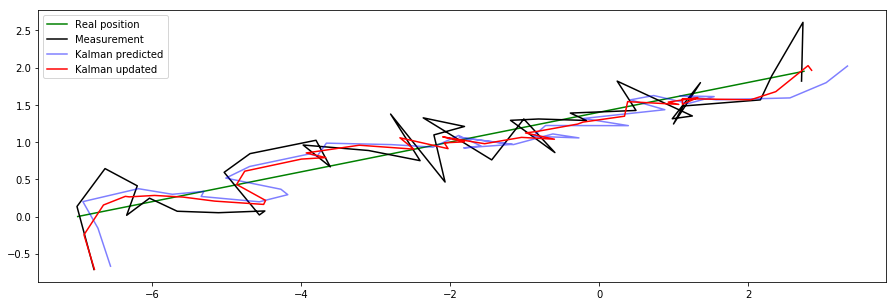

In [6]:
plt.figure(figsize=(18, 5))
plt.subplot(111, aspect='equal')
plt.plot(real_track[:,0], real_track[:,1], c='green', label='Real position')
plt.plot(gnss_track[:,0], gnss_track[:,1], c='black', label="Measurement")
plt.plot(kalman_predicted_positions[1:,0], kalman_predicted_positions[1:,1], 
         c='blue', label="Kalman predicted", alpha=0.5)  # skip the first prediction as its variance is too high
plt.plot(kalman_updated_positions[:,0], kalman_updated_positions[:,1], c='red', label="Kalman updated")
plt.legend()

Обратный проход по данным:

In [7]:
def backward(kalman_filter, predicted_positions, predicted_variances, 
             updated_positions, updated_variances, velocity_measures, 
             timestamps):
    rts_updated_positions = [updated_positions[-1]]
    rts_updated_variances = [updated_variances[-1]]
    n_measures = len(velocity_measures)

    # TODO implement full backward pass through measured data, use backward method, 
    # store the results in rts_updated_positions and rts_updated_variances

    
    # don't forget to reverse the result predictions 
    return np.array(rts_updated_positions), np.array(rts_updated_variances)

In [8]:
res = backward(kalman_filter, kalman_predicted_positions, kalman_predicted_variances, 
               kalman_updated_positions, kalman_updated_variances, velocity_measures, timestamps)
kalman_rts_updated_positions, kalman_rts_updated_variances = res

Визуализация того, что получилось после обновления. Если все правильно, то траектория должна получиться более плавной.

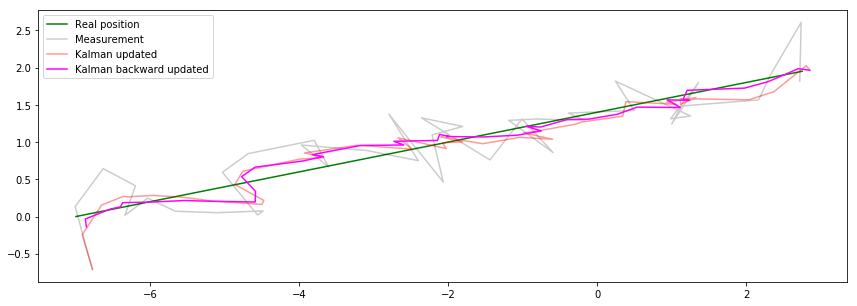

In [9]:
plt.figure(figsize=(18, 5))
plt.subplot(111, aspect='equal')
plt.plot(real_track[:,0], real_track[:,1], c='green', label='Real position')
plt.plot(gnss_track[:,0], gnss_track[:,1], c='black', label="Measurement", alpha=0.2)
plt.plot(kalman_updated_positions[:,0], kalman_updated_positions[:,1], c='red', label="Kalman updated", alpha=0.4)
plt.plot(kalman_rts_updated_positions[:,0], kalman_rts_updated_positions[:,1], c='magenta', label="Kalman backward updated")
plt.legend()